In [1]:
from oads_access.oads_access import OADS_Access
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from result_manager.result_manager import ResultManager

In [2]:
home_path = os.path.expanduser('~')
result_manager = ResultManager(root=f'{home_path}/projects/oads_results/')

In [3]:
identifier = {
    # 'resnet10': { # normalized
    #     'rgb': {'raw': ('2023-06-05-09:26:12', '05-06-23-12:08:31'), 'jpeg': ('2023-06-05-13:58:12', '05-06-23-13:58:28')},
    #     'coc': {'raw': ('2023-05-31-09:26:12', '05-06-23-09:43:06'), 'jpeg': ('2023-06-05-13:57:12', '05-06-23-13:58:00')},
    # },
    'resnet10': { 
        'rgb': {'raw': ('2023-06-05-09:26:12', '05-06-23-12:08:31'), 'jpeg': ('2023-06-12-11:25:21', '')},
        'coc': {'raw': ('2023-06-12-11:25:21', '12-06-23-11:33:03'), 'jpeg': ('2023-06-12-11:25:21', '')}, # not normalized
    },
    # 'resnet18': { # normalized with RGB mean, std
    #     'rgb': {'raw': ('2023-06-05-16:45:19', '05-06-23-16:45:21'), 'jpeg': ('2023-06-05-16:45:19', '05-06-23-22:19:33')},
    #     'coc': {'raw': ('2023-06-05-16:45:19', '05-06-23-19:41:30'), 'jpeg': ('2023-06-05-16:45:19', '06-06-23-00:48:51')},
    # },
    'resnet18': { # normalized with correct (RGB and COC, respectively) mean, std
        'rgb': {'raw': ('2023-06-05-16:45:19', '05-06-23-16:45:21'), 'jpeg': ('2023-06-05-16:45:19', '')},
        'coc': {'raw': ('2023-06-12-17:49:12', '12-06-23-23:05:26'), 'jpeg': ('2023-06-05-16:45:19', '')},
    },
    'resnet50': {
        'rgb': {'raw': ('2023-06-05-16:46:19', '05-06-23-16:46:23'), 'jpeg': ('2023-06-05-16:46:19', '06-06-23-03:32:43')},
        'coc': {'raw': ('2023-06-05-16:46:19', '05-06-23-22:23:07'), 'jpeg': ('2023-06-05-16:46:19', '06-06-23-07:03:36')},
    },
    # 'alexnet': {
    #     'rgb': {'raw': ('2023-06-08-11:54:21', '08-06-23-11:54:24'), 'jpeg': ('', '')}, # Change dates for best models
    #     'coc': {'raw': ('2023-06-08-11:54:21', '08-06-23-13:27:29'), 'jpeg': ('', '')},
    # },
    'alexnet': {
        'rgb': {'raw': ('2023-06-08-11:54:21', '08-06-23-18:24:04'), 'jpeg': ('2023-06-08-11:54:21', '08-06-23-21:09:57')}, # Change dates for best models
        'coc': {'raw': ('2023-06-08-11:54:21', '09-06-23-14:03:14'), 'jpeg': ('2023-06-08-11:54:21', '08-06-23-22:33:54')},
    },
    'vgg11_bn': {
        'rgb': {'raw': ('2023-06-09-12:33:35', '09-06-23-12:33:37'), 'jpeg': ('2023-06-09-12:33:35', '10-06-23-04:50:58')}, # Change dates for best models
        'coc': {'raw': ('2023-06-09-12:33:35', '09-06-23-20:48:57'), 'jpeg': ('2023-06-09-12:33:35', '10-06-23-13:16:50')},
    },
}

identifier_cv = '2023-06-06-18:04:08_CV'
                #  {
                #     'resnet10': {
                #         'rgb': {'raw': '', 'jpeg': ''}, 'coc': {'raw': '', 'jpeg': ''},
                #         'coc': {'raw': '', 'jpeg': ''}, 'coc': {'raw': '', 'jpeg': ''},
                #     },
                #  })

# Verify test accuracy

In [13]:
num_workers = 4
oads = OADS_Access(basedir=f'{home_path}/projects/data/oads', n_processes=num_workers, file_formats=['.ARW', '.tiff'])

batch_size = 32
use_crops = True
preload_all = False

size = (400, 400)

In [65]:
_, val_ids, test_ids = oads.get_train_val_test_split_indices(use_crops=use_crops)

In [48]:
from pytorch_utils.resnet10 import ResNet10
from torchvision import transforms
from oads_access.oads_access import OADS_Access, OADSImageDataset
import torch
from torch.utils.data import DataLoader
from pytorch_utils.pytorch_utils import collate_fn, ToOpponentChannel, evaluate

In [46]:
output_channels = len(oads.get_class_mapping())
class_index_mapping = {}
index_label_mapping = {}
for index, (key, item) in enumerate(list(oads.get_class_mapping().items())):
    class_index_mapping[key] = index
    index_label_mapping[index] = item

# OADS Crops (400,400) mean, std
mean = [0.3410, 0.3123, 0.2787]
std = [0.2362, 0.2252, 0.2162]

device = torch.device('cuda:0')

In [66]:
loaders = {}
for image_representation in ['rgb', 'coc']:
    loaders[image_representation] = {}

    for image_quality in ['raw', 'jpeg']:
        ############################################ Load OADS
        oads = OADS_Access(basedir=f'{home_path}/projects/data/oads', n_processes=num_workers, use_jpeg=True if image_quality == 'jpeg' else False)
        # Get the custom dataset and dataloader
        print(f"Getting data loaders")
        transform_list = []
        transform_list.append(transforms.Resize(size))

        # Apply color opponnent channel representation
        if image_representation == 'coc':
            transform_list.append(ToOpponentChannel())

        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize(mean, std))

        transform = transforms.Compose(transform_list)

        ############################################
        # Created custom OADS datasets
        # traindataset = OADSImageDataset(oads_access=oads, item_ids=train_ids, use_crops=use_crops, preload_all=preload_all,
        #                                 class_index_mapping=class_index_mapping, transform=transform, device=device)
        valdataset = OADSImageDataset(oads_access=oads, item_ids=val_ids, use_crops=use_crops, preload_all=preload_all,
                                        class_index_mapping=class_index_mapping, transform=transform, device=device)
        testdataset = OADSImageDataset(oads_access=oads, item_ids=test_ids, use_crops=use_crops, preload_all=False, target='label', return_index=True,
                                        class_index_mapping=class_index_mapping, transform=transform, device=device)

        # Create loaders - shuffle training set, but not validation or test set
        # trainloader = DataLoader(traindataset, collate_fn=collate_fn,
        #                             batch_size=batch_size, shuffle=True, num_workers=oads.n_processes)
        # valloader = DataLoader(valdataset, collate_fn=collate_fn,
        #                         batch_size=batch_size, shuffle=False, num_workers=oads.n_processes)
        testloader = DataLoader(testdataset, collate_fn=collate_fn,
                                batch_size=batch_size, shuffle=False, num_workers=oads.n_processes)
        
        loaders[image_representation][image_quality] = testloader

Getting data loaders
Getting data loaders
Getting data loaders
Getting data loaders


In [67]:
for model_type in ['resnet10']:
    for image_representation in ['rgb', 'coc']:
        for image_quality in ['raw', 'jpeg']:
            
            if image_quality == 'jpeg':
                quality_folder = f'jpeg/{identifier[model_type][image_representation][image_quality][0]}'
            else:
                quality_folder = identifier[model_type][image_representation][image_quality][0]

            model_ident = identifier[model_type][image_representation][image_quality][1]

            if model_type == 'resnet10':
                model = ResNet10(n_output_channels=21, n_input_channels=3)

            model_path = os.path.join(home_path, 'projects', 'oads_results', model_type, image_representation, quality_folder, f'best_model_{model_ident}.pth')

            try:
                model.load_state_dict(torch.load(model_path))
            except:
                model = torch.nn.DataParallel(model)
                model.load_state_dict(torch.load(model_path))
            
            model = model.module
            model = model.to(device=device)

            criterion = torch.nn.CrossEntropyLoss()

            res = evaluate(loader=loaders[image_representation][image_quality], model=model, device=device, criterion=criterion)
            print(model_type, image_representation, image_quality, res['accuracy'])


100%|██████████| 271/271 [00:28<00:00,  9.53it/s]


resnet10 rgb raw 0.8226310308920514


100%|██████████| 271/271 [00:17<00:00, 15.89it/s]


resnet10 rgb jpeg 0.8265648501677658


100%|██████████| 271/271 [00:24<00:00, 11.07it/s]


resnet10 coc raw 0.826449149600833


100%|██████████| 271/271 [00:22<00:00, 11.90it/s]

resnet10 coc jpeg 0.8230938331597825


# Performance

In [4]:
cols = ['model_type', 'image_representation', 'image_quality', 'metric', 'value']
rows = []

cols_loss = ['model_type', 'image_representation', 'image_quality', 'condition', 'epoch', 'metric', 'value']
rows_loss = []

for model_type in ['resnet10', 'resnet18', 'resnet50', 'alexnet', 'vgg11_bn']:
    for image_representation in ['rgb', 'coc']:
        for image_quality in ['raw']: # , 'jpeg'
            
            if image_quality == 'jpeg':
                quality_folder = f'jpeg/{identifier[model_type][image_representation][image_quality][0]}'
            else:
                quality_folder = identifier[model_type][image_representation][image_quality][0]

            model_ident = identifier[model_type][image_representation][image_quality][1]

            # if 'no_norm' in model_type:
            #     model_type = 'resnet10'

            results = result_manager.load_result(filename=f'training_results_{model_ident}.yml', path=os.path.join(home_path, 'projects', 'oads_results', model_type, image_representation, quality_folder))

            if results is None:
                continue

            # results['eval_trained_traindata']['accuracy']
            for metric in ['eval_trained_traindata', 'eval_trained_testdata', 'eval_trained_valdata']:
                # print(model_type, image_representation, model_ident, metric, results[metric]['accuracy'])
                rows.append([
                    model_type, image_representation, image_quality, f'{metric}_accuracy', results[metric]['accuracy']
                ])

            for epoch, loss in enumerate(results['training_losses']):
                rows_loss.append([
                    model_type, image_representation, image_quality, f'training', epoch, 'loss', loss
                ])

            epoch = 0
            while True:
                if f'validation_during_training_epoch-{epoch}' in results:
                    acc = results[f'validation_during_training_epoch-{epoch}']['accuracy']
                    batch_loss = np.mean(list(results[f'validation_during_training_epoch-{epoch}']['batch_losses'].values()))

                    rows_loss.append([
                        model_type, image_representation, image_quality, f'validation_during_training', epoch, 'accuracy', acc
                    ])
                    rows_loss.append([
                        model_type, image_representation, image_quality, f'validation_during_training', epoch, 'loss', batch_loss
                    ])

                    epoch += 1
                else:
                    break

In [5]:
df = pd.DataFrame(data=rows, columns=cols)
df_loss = pd.DataFrame(data=rows_loss, columns=cols_loss)

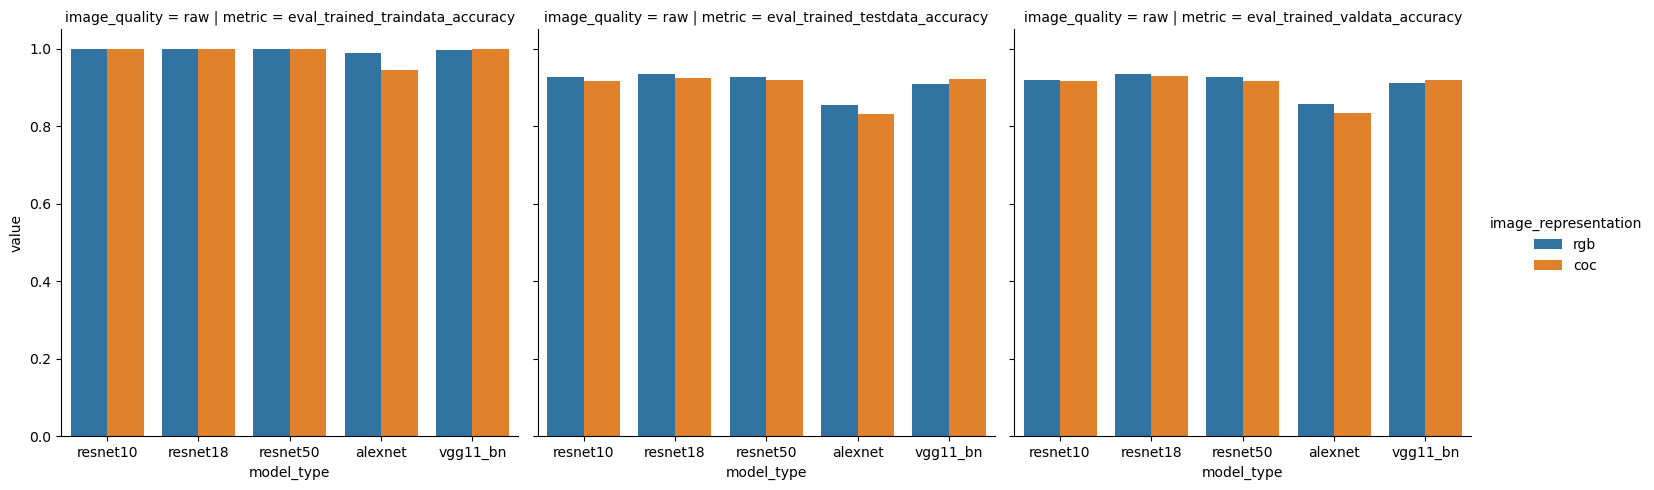

In [6]:
g = sns.catplot(data=df, kind='bar', x='model_type', row='image_quality', col='metric', hue='image_representation', y='value')
# g.set_xticklabels(['Training', 'Test', 'Validation'])
# g.set_axis_labels('Acucracy', '')
# g.set_titles('{col_name}')

Text(0.5, 0.98, 'Testset')

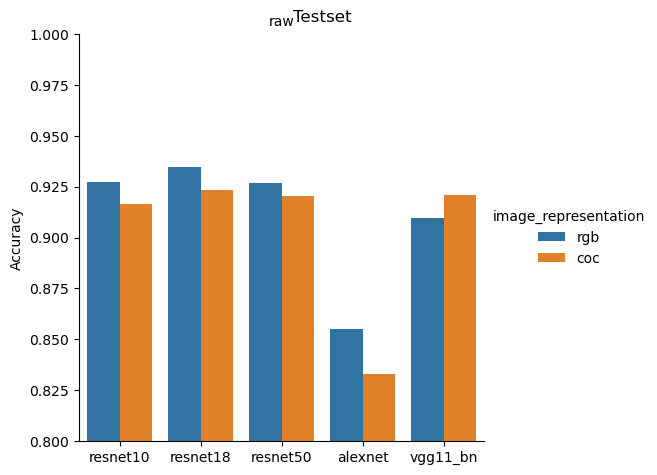

In [7]:
g = sns.catplot(data=df[df['metric'] == 'eval_trained_testdata_accuracy'], kind='bar', x='model_type', col='image_quality', hue='image_representation', y='value')
g.set(ylim=(0.8, 1))
g.set_axis_labels('', 'Accuracy')
g.set_titles('{col_name}')
g.fig.suptitle('Testset')

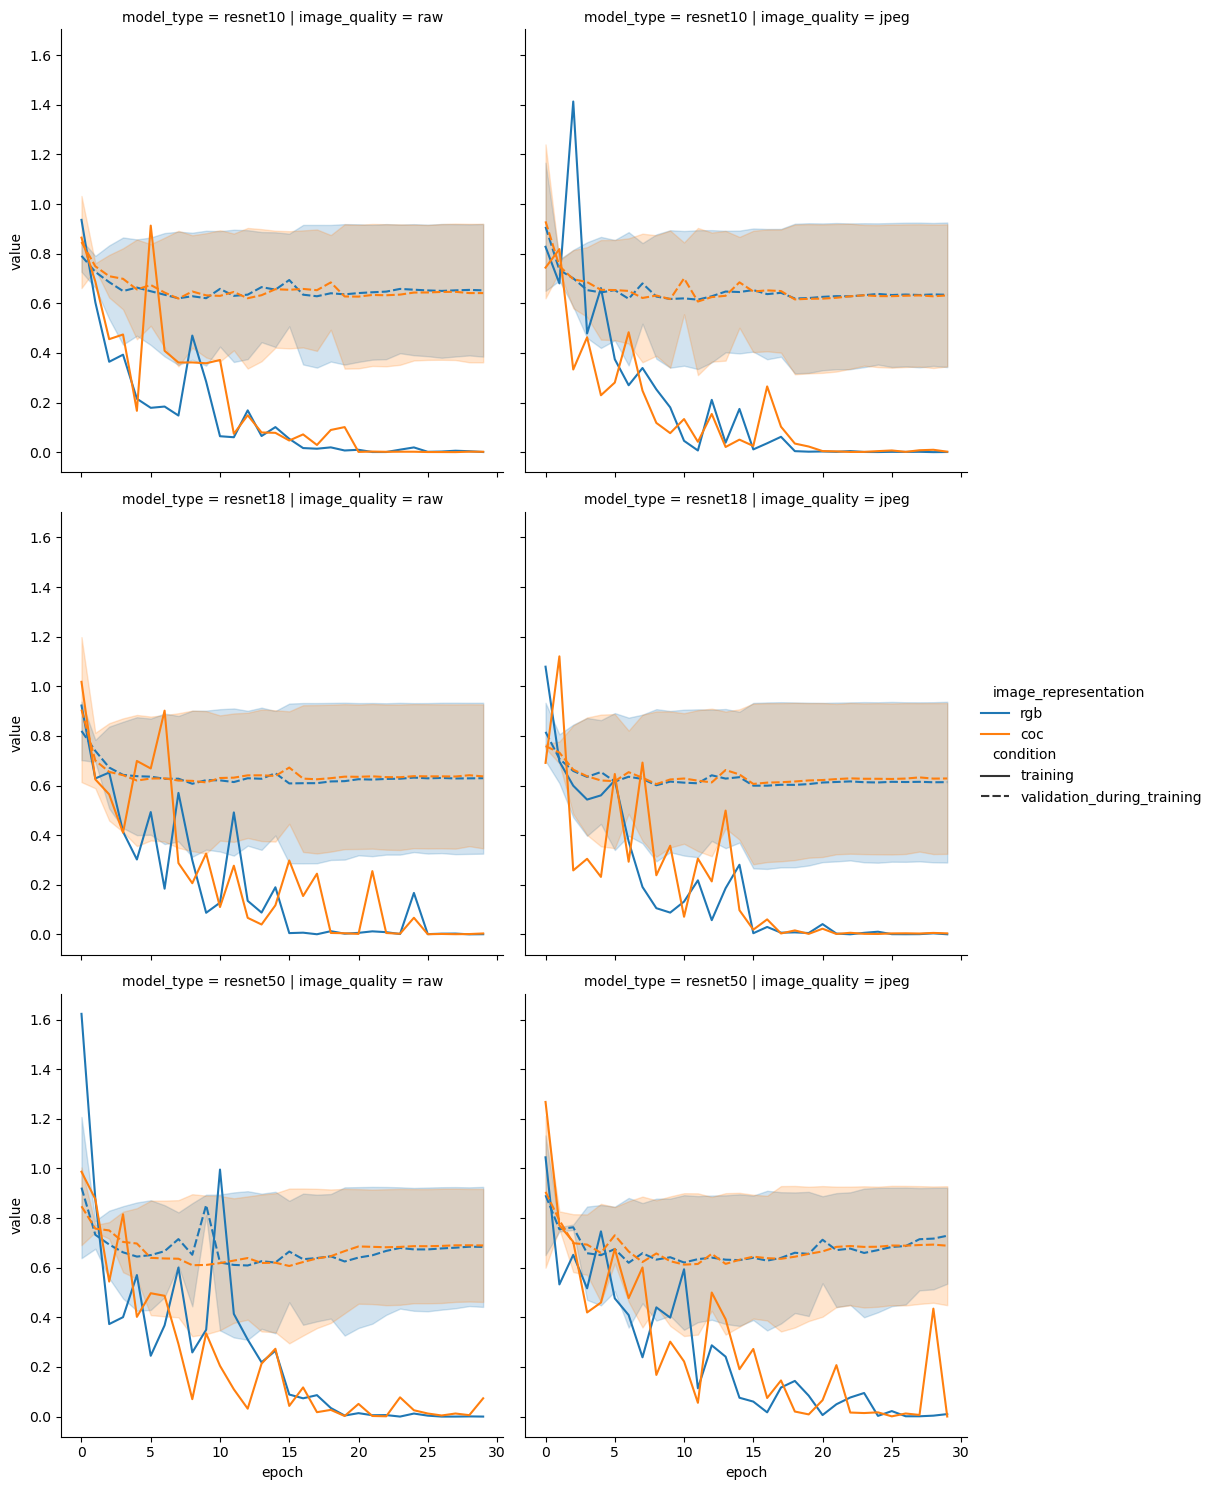

In [46]:
sns.relplot(data=df_loss, kind='line', x='epoch', y='value', hue='image_representation', col='image_quality', row='model_type', style='condition')

# Cross-Validation

In [16]:
cols_cv = ['model_type', 'image_representation', 'image_quality', 'fold', 'metric', 'value']
rows_cv = []

cols_loss_cv = ['model_type', 'image_representation', 'image_quality', 'fold', 'condition', 'epoch', 'metric', 'value']
rows_loss_cv = []

for model_type in ['resnet10']:#, 'resnet18', 'resnet50']:
    for image_representation in ['rgb', 'coc']:#, 'coc']:
        for image_quality in ['raw']:#, 'jpeg']:
            
            if image_quality == 'jpeg':
                quality_folder = f'jpeg/{identifier_cv}'
            else:
                quality_folder = identifier_cv

            cv_folder = os.path.join(home_path, 'projects', 'oads_results', model_type, image_representation, quality_folder)
            seeds = os.listdir(cv_folder)

            for fold, seed in enumerate(seeds):
                model_ident = [x.split('best_model_')[-1].split('.pth')[0] for x in os.listdir(os.path.join(cv_folder, seed)) if 'best_model' in x][0]
                # model_ident = identifier[model_type][image_representation][image_quality][1]

                results = result_manager.load_result(filename=f'training_results_{model_ident}.yml', path=os.path.join(home_path, 'projects', 'oads_results', model_type, image_representation, quality_folder, seed))

                # results['eval_trained_traindata']['accuracy']
                for metric in ['eval_trained_traindata', 'eval_trained_testdata', 'eval_trained_valdata']:
                    rows_cv.append([
                        model_type, image_representation, image_quality, fold, f'{metric}_accuracy', results[metric]['accuracy']
                    ])

                for epoch, loss in enumerate(results['training_losses']):
                    rows_loss_cv.append([
                        model_type, image_representation, image_quality, fold, f'training', epoch, 'loss', loss
                    ])

                epoch = 0
                while True:
                    if f'validation_during_training_epoch-{epoch}' in results:
                        acc = results[f'validation_during_training_epoch-{epoch}']['accuracy']
                        batch_loss = np.mean(list(results[f'validation_during_training_epoch-{epoch}']['batch_losses'].values()))

                        rows_loss_cv.append([
                            model_type, image_representation, image_quality, fold, f'validation_during_training', epoch, 'accuracy', acc
                        ])
                        rows_loss_cv.append([
                            model_type, image_representation, image_quality, fold, f'validation_during_training', epoch, 'loss', batch_loss
                        ])

                        epoch += 1
                    else:
                        break

KeyError: 'eval_trained_traindata'

In [20]:
df_cv = pd.DataFrame(data=rows_cv, columns=cols_cv)
df_loss_cv = pd.DataFrame(data=rows_loss_cv, columns=cols_loss_cv)

Text(0.5, 0.98, 'Testset')

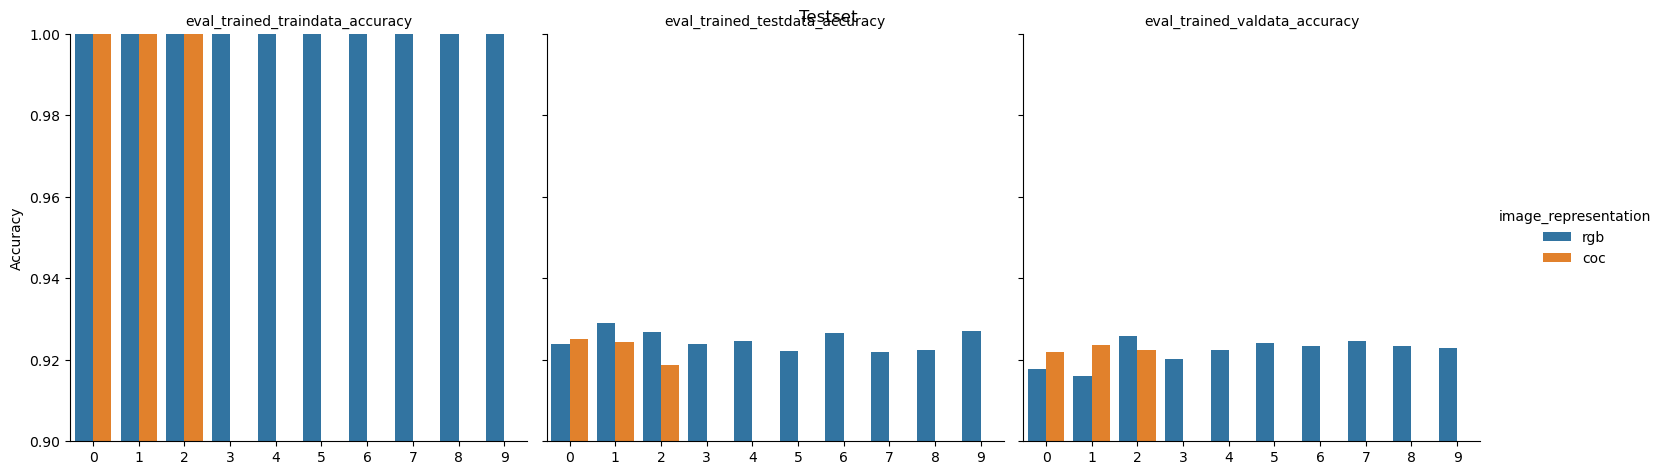

In [19]:
g = sns.catplot(data=df_cv, kind='bar', x='fold', row='image_quality', col='metric', hue='image_representation', y='value')
g.set(ylim=(0.9, 1))
g.set_axis_labels('', 'Accuracy')
g.set_titles('{col_name}')
g.fig.suptitle('Testset')

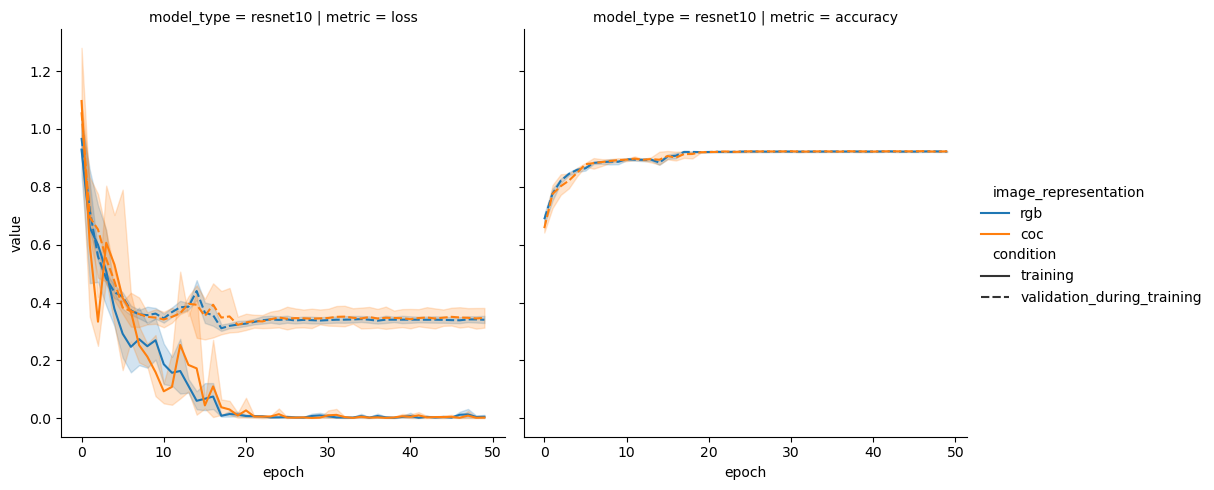

In [22]:
sns.relplot(data=df_loss_cv, kind='line', x='epoch', y='value', hue='image_representation', col='metric', row='model_type', style='condition')